In [1]:
'''
pip install ipywidgets --upgrade
'''

'\npip install ipywidgets --upgrade\n'

In [2]:

# !pip install ipywidgets --upgrade
# !pip install -r /dccstor/fluidos/luba_dev/fluidos-model-orchestrator/requirements-dev.txt



In [3]:
import os
from pathlib import Path
# import sys
# base_path = Path(os.path.abspath("")).parent.parent
# sys.path.append(base_path.as_posix())
# base_path.as_posix()

In [4]:
# !pip install /dccstor/fluidos/luba_dev/fluidos-model-orchestrator/

In [5]:

import logging
import random
import shutil
from pathlib import Path
from typing import Any
import os

import numpy as np  # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf  # type: ignore
import torch  # type: ignore
import matplotlib.pyplot as plt

# from fluidos_model_orchestrator.data_pipeline.augmentation import AUGMENTATION_TYPES
# from fluidos_model_orchestrator.data_pipeline.augmentation.augmentation_pipeline import create_augmented_dataset_df
# from fluidos_model_orchestrator.data_pipeline.data_processor_factory import DataProcessorFactory
# from fluidos_model_orchestrator.data_pipeline.data_util import FLUIDOS_DATASETS
# from fluidos_model_orchestrator.data_pipeline.data_util import get_target_column
# from fluidos_model_orchestrator.data_pipeline.data_util import load_ml_ready_df
from fluidos_model_orchestrator.model.utils import MODEL_TYPES
# from fluidos_model_orchestrator.model_pipeline.model_trainer_factory import ModelTrainerFactory
# from fluidos_model_orchestrator.util import get_default_output_dir_path
# from fluidos_model_orchestrator.util import reset_output_dir
from fluidos_model_orchestrator.model.utils import FLUIDOS_COL_NAMES

import ipywidgets as widgets
widgets.IntSlider()

tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

## Hyperparameters

In [6]:
ROOT_DIR = Path(os.getcwd()).parent.parent

platform = "ccc"
dataset_name = FLUIDOS_DATASETS.BITBRAINS  # FLUIDOS_DATASETS.GCT
model_type = MODEL_TYPES.CG  # MODEL_TYPES.FLUIDOS_RANKER
augmentation = AUGMENTATION_TYPES.FEEDBACK_LOOP  # AUGMENTATION_TYPES.PERFORMANCE_RATING

epochs = 5
load_from_generated = 0
test_mode = False
max_pod = 2000
tr_number = 50 # -1 for gct

path_output_model = "/dccstor/fluidos/luba_dev/tid_bitbrains_100k/"
path_output = "/dccstor/fluidos/luba_dev/tid_bitbrains_100k"
dataset_subset = "rnd"
# path_dataset_ml_ready = None
# path_dataset_ml_ready = "/dccstor/fluidos/luba_dev/tid_bitbrains_100k/dataset/bitbrains_v0_train/ml_ready_augmented/feedback_loop"
path_dataset_ml_ready = '/Users/killianlevacher/Downloads/feedback_loop'

MODEL_SOURCE = "model_source"
FED_MODELS_TRAINED = [MODEL_SOURCE, "model_B", "model_C"]

In [7]:

def get_default_dev_datasets_path(dataset_name: str) -> str:
    # fluidos-model-orchestrator
    return Path(f"/dccstor/fluidos/datasets/{dataset_name}/original").as_posix()
    # return Path(ROOT_DIR, f"tests/dataset_resources/original_dataset_{dataset_name}").as_posix()


def create_default_dev_augmented_ml_ready_dataset(dataset_name: str,
                                                  subset: str,
                                                  tmp_test_path: Path,
                                                  augmentation_types: list[str],
                                                  max_pods: int = 10000) -> tuple[Path, pd.DataFrame, pd.DataFrame]:

    dataset_processor = DataProcessorFactory().create_dataset_processor(
        dataset_name,
        original_dataset_path=Path(get_default_dev_datasets_path(dataset_name)),
        output_dataset_path=tmp_test_path,
        dataset_version="0",
        pods_number=max_pods,
        mode="train",
        tr_number=tr_number
    )
    dataset_processor.create_source_dataset(subset=subset, cache=True)

    # #TODO probably can remove datasetname
    dataset_processor.create_ml_ready_dataset_df(cache=True)
    ml_augmented_path, _ = create_augmented_dataset_df(augmentation_types,
                                                       dataset_processor.ml_ready_path,
                                                       dataset_processor.ml_ready_augmented_path,
                                                       dataset_processor.metadata_obj,
                                                       dataset_name,
                                                       cache=True)

    ml_ready_augmented_path = ml_augmented_path.joinpath(augmentation_types[0])
    pods_assigment_df, template_resources_df = load_ml_ready_df(ml_ready_augmented_path)

    return ml_ready_augmented_path, pods_assigment_df, template_resources_df

In [8]:
def split_dataset(df: pd.DataFrame, model_names: list[str], model_source_name: str, train_ratio: float = 0.2, test_ratio: float = 0.05) -> dict[str, dict[str, Any]]:

    manifests = df[[FLUIDOS_COL_NAMES.POD_FILE_NAME, FLUIDOS_COL_NAMES.POD_MANIFEST]]
    counts = manifests[FLUIDOS_COL_NAMES.POD_MANIFEST].value_counts().to_dict()
    # Estimation of pod manifests distribution
    frequency_per_pod = []
    for index, row in manifests.iterrows():
        frequency_per_pod.append(counts[row[FLUIDOS_COL_NAMES.POD_MANIFEST]])

    manifests.insert(2, "frequency", frequency_per_pod)
    manifests = manifests.sort_values(by="frequency", ascending=False)
    manifests["frequency"] = manifests["frequency"] / len(manifests)
    manifests.index = range(len(manifests.index))
    manifests = manifests.reset_index()

    manifests_size = len(manifests)

    train_size = int(train_ratio * manifests_size)
    test_size = int(test_ratio * manifests_size) 
    test_manifests = manifests.sample(test_size)

    train_manifests = manifests[:train_size]
    local_manifests = manifests[train_size:]

    train_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(train_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    local_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(local_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    test_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(test_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    split_size = len(local_pods) // (len(model_names) - 1)
    local_pods_chunks = [local_pods[i:i + split_size] for i in range(0, len(local_pods), split_size)]

    model_attributes = {}
    model_attributes[MODEL_SOURCE] = {"df_train": train_pods, "df_test": test_pods}
    for index, model_name in enumerate(model_names[1:]):
        model_attributes[model_name] = {"df_train": local_pods_chunks[index],
                                        "df_test": test_pods}
            
    return model_attributes

## Preparing Datasets

In [9]:

logging.info("Starting Model Building and Training")

if path_output is None:
    path_output = str(get_default_output_dir_path())

if platform != "ccc":
    reset_output_dir(Path(path_output))

# '/Users/killianlevacher/GIT/project-fluidos/tests/dataset_resources/sample_dataset_GCT'
# /Users/killianlevacher/GIT/project-fluidos/                           tests/dataset_resources/sample_dataset_GCT
# /Users/killianlevacher/GIT/project-fluidos/fluidos-model-orchestrator/tests/dataset_resources/sample_dataset_GCT/table-a.csv
# if path_dataset_ml_ready is None:
#     ml_ready_dataset_path, pods_assigment_df, template_resources_df = create_default_dev_augmented_ml_ready_dataset(dataset_name,
#                                                                                                                     dataset_subset,
#                                                                                                                     Path(path_output).joinpath("dataset"),
#                                                                                                                     [augmentation],
#                                                                                                                     max_pod)
# else:
ml_ready_dataset_path = Path(path_dataset_ml_ready)

pods_assigment_df, template_resources_df = load_ml_ready_df(ml_ready_dataset_path)

model_attributes = split_dataset(pods_assigment_df, FED_MODELS_TRAINED, MODEL_SOURCE)

Loading dataset: /dccstor/fluidos/luba_dev/tid_bitbrains_100k/dataset/bitbrains_v0_train/ml_ready_augmented/feedback_loop


Exception: Path to ml_ready dataset does not exist. Path was: /dccstor/fluidos/luba_dev/tid_bitbrains_100k/dataset/bitbrains_v0_train/ml_ready_augmented/feedback_loop

pods_assigment_df## Setting up model Trainers

In [ ]:
if dataset_name == FLUIDOS_DATASETS.BITBRAINS:
    total_pods = max_pod * tr_number
else:
    total_pods = max_pod
    
for model_name in FED_MODELS_TRAINED:
    model_trainer = ModelTrainerFactory.create_model_trainer(model_type,
                                                                ml_ready_dataset_path,
                                                                Path(path_output).joinpath("model_training"),
                                                                max_pod=total_pods,
                                                                epochs=epochs,
                                                                target_column=get_target_column(augmentation),
                                                                load_from_generated=load_from_generated,
                                                                # load_from_generated=True,
                                                                model_name=model_name)
    model_trainer.prepare_directories()
    model_attributes[model_name]["trainer"] = model_trainer

for model_name in FED_MODELS_TRAINED:
    TRAINING_RATIO = 1.0
    cached_train = model_attributes[model_name]["trainer"].prepare_dataset(model_attributes[model_name]['df_train'],
                                                                                template_resources_df, test_mode,
                                                                                training_size_ratio=TRAINING_RATIO,
                                                                                model_tag=model_name, dataset_type="train")
    cached_test = model_attributes[model_name]["trainer"].prepare_dataset(model_attributes[model_name]['df_test'],
                                                                                template_resources_df, test_mode,
                                                                                training_size_ratio=TRAINING_RATIO,
                                                                                model_tag=model_name, dataset_type="test")
    model_attributes[model_name]["trainer"].cached_train = cached_train
    model_attributes[model_name]["trainer"].cached_test = cached_test

Creating model trainer
Preparing directories
Creating model trainer
Preparing directories
Creating model trainer
Preparing directories
Subset shape 20000


Embeddings generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:23<00:00,  2.06s/it]


Subset shape 5120


Embeddings generation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:25<00:00,  2.13s/it]


Subset shape 40000


Embeddings generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [10:42<00:00,  2.05s/it]


Subset shape 5120


Embeddings generation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:13<00:00,  1.84s/it]


Subset shape 40000


Embeddings generation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [08:07<00:00,  1.56s/it]


Subset shape 5120


Embeddings generation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:03<00:00,  1.58s/it]


## Training source model

In [ ]:

model_attributes[MODEL_SOURCE]["trainer"].build_model()
model_attributes[MODEL_SOURCE]["trainer"].check_model_dataset_depencies()
model_attributes[MODEL_SOURCE]["trainer"].train_model()
model_attributes[MODEL_SOURCE]["eval_results"] = model_attributes[MODEL_SOURCE]["trainer"].evaluate()

for model_name in FED_MODELS_TRAINED:
    if model_name == MODEL_SOURCE:
        continue
    shutil.copytree(model_attributes[MODEL_SOURCE]["trainer"].checkpoint_path.parent.parent.parent, model_attributes[model_name]["trainer"].checkpoint_path.parent.parent.parent, dirs_exist_ok=True)
    # shutil.copytree(model_attributes[MODEL_SOURCE]["trainer"].checkpoint_path.parent.parent, model_attributes[model_name]["trainer"].checkpoint_path.parent.parent, dirs_exist_ok=True)


Training...


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:24<00:00, 103.96batch/s, accuracy=1, loss=2.98]


Epoch 0, train loss 3.077 Accuracy 0.9 LR: [0.0001]


(val) Epoch 0:   0%|                                                                                                        | 0/640 [00:06<?, ?batch/s, v_accuracy=0.75, val_loss=3.19]


Epoch 0, val loss 3.4473 Accuracy 0.5
Current minimal val loss is 3.4473040733486413.


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 124.80batch/s, accuracy=1, loss=2.95]


Epoch 1, train loss 2.9703 Accuracy 0.98 LR: [0.0001]


(val) Epoch 1:   0%|                                                                                                        | 0/640 [00:04<?, ?batch/s, v_accuracy=0.75, val_loss=3.27]


Epoch 1, val loss 3.4087 Accuracy 0.53
Current minimal val loss is 3.408718976005912.


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 119.21batch/s, accuracy=1, loss=2.95]


Epoch 2, train loss 2.971 Accuracy 0.98 LR: [1e-05]


(val) Epoch 2:   0%|                                                                                                        | 0/640 [00:03<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 2, val loss 3.3686 Accuracy 0.58
Current minimal val loss is 3.368578790128231.


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 131.36batch/s, accuracy=1, loss=2.95]


Epoch 3, train loss 2.9666 Accuracy 0.98 LR: [1e-05]


(val) Epoch 3:   0%|                                                                                                        | 0/640 [00:04<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 3, val loss 3.3685 Accuracy 0.58
Current minimal val loss is 3.3685213826596736.


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 110.35batch/s, accuracy=1, loss=2.95]


Epoch 4, train loss 2.9665 Accuracy 0.98 LR: [1e-05]


(val) Epoch 4:   0%|                                                                                                        | 0/640 [00:04<?, ?batch/s, v_accuracy=0.75, val_loss=3.19]


Epoch 4, val loss 3.3621 Accuracy 0.58
Current minimal val loss is 3.3621345281600954.
("Evaluation results: {'total_loss': 3.3621345281600954, 'accuracy': "
 '0.5837890625}')


## Training Child Models from Source Model

In [ ]:


for model_name in FED_MODELS_TRAINED:
    if model_name == MODEL_SOURCE:
        continue
    print(model_name)
    model_attributes[model_name]["trainer"].load_model(load_from_checkpoint=True)  # type: ignore
    model_attributes[model_name]["trainer"].train_model()
    model_attributes[model_name]["eval_results"] = model_attributes[model_name]["trainer"].evaluate()

logging.info("MODELS Evaluation Results")
for model_name in FED_MODELS_TRAINED:
    if "eval_results" in model_attributes[model_name]:
        logging.info(f"MODEL: {model_name}: {model_attributes[model_name]['eval_results']}")

logging.info(f"Pipeline output located at: {path_output_model}")


model_B
Training...


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:49<00:00, 101.08batch/s, accuracy=0.5, loss=3.44]


Epoch 0, train loss 3.309 Accuracy 0.64 LR: [0.0001]


(val) Epoch 0:   0%|                                                                                                        | 0/640 [00:04<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 0, val loss 3.3224 Accuracy 0.62
Current minimal val loss is 3.322444659471512.


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 99.20batch/s, accuracy=0.88, loss=3.07]


Epoch 1, train loss 3.2098 Accuracy 0.74 LR: [0.0001]


(val) Epoch 1:   0%|                                                                                                        | 0/640 [00:05<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 1, val loss 3.153 Accuracy 0.79
Current minimal val loss is 3.1530446887016295.


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 99.68batch/s, accuracy=0.88, loss=3.07]


Epoch 2, train loss 3.1983 Accuracy 0.75 LR: [1e-05]


(val) Epoch 2:   0%|                                                                                                        | 0/640 [00:03<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


Epoch 2, val loss 3.1647 Accuracy 0.78


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:40<00:00, 124.44batch/s, accuracy=0.62, loss=3.32]


Epoch 3, train loss 3.1887 Accuracy 0.76 LR: [1e-05]


(val) Epoch 3:   0%|                                                                                                        | 0/640 [00:03<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


Epoch 3, val loss 3.1645 Accuracy 0.78


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 125.24batch/s, accuracy=0.75, loss=3.19]


Epoch 4, train loss 3.1885 Accuracy 0.76 LR: [1e-05]


(val) Epoch 4:   0%|                                                                                                        | 0/640 [00:05<?, ?batch/s, v_accuracy=0.88, val_loss=3.07]


Epoch 4, val loss 3.1632 Accuracy 0.78
"Evaluation results: {'total_loss': 3.163152886554599, 'accuracy': 0.781640625}"
model_C
Training...


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.36batch/s, accuracy=0.75, loss=3.2]


Epoch 0, train loss 3.3199 Accuracy 0.63 LR: [0.0001]


(val) Epoch 0:   0%|                                                                                                        | 0/640 [00:04<?, ?batch/s, v_accuracy=0.75, val_loss=3.19]


Epoch 0, val loss 3.316 Accuracy 0.63
Current minimal val loss is 3.316000550240278.


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:48<00:00, 103.92batch/s, accuracy=0.62, loss=3.32]


Epoch 1, train loss 3.2537 Accuracy 0.69 LR: [0.0001]


(val) Epoch 1:   0%|                                                                                                        | 0/640 [00:03<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 1, val loss 3.3143 Accuracy 0.63
Current minimal val loss is 3.3142888523638248.


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 108.96batch/s, accuracy=0.75, loss=3.2]


Epoch 2, train loss 3.2691 Accuracy 0.68 LR: [1e-05]


(val) Epoch 2:   0%|                                                                                                        | 0/640 [00:07<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 2, val loss 3.3044 Accuracy 0.64
Current minimal val loss is 3.3043787121772765.


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 98.97batch/s, accuracy=0.75, loss=3.19]


Epoch 3, train loss 3.2499 Accuracy 0.7 LR: [1e-05]


(val) Epoch 3:   0%|                                                                                                        | 0/640 [00:05<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 3, val loss 3.301 Accuracy 0.64
Current minimal val loss is 3.3010287672281264.


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.97batch/s, accuracy=0.88, loss=3.07]


Epoch 4, train loss 3.207 Accuracy 0.74 LR: [1e-05]


(val) Epoch 4:   0%|                                                                                                         | 0/640 [00:04<?, ?batch/s, v_accuracy=0.75, val_loss=3.2]


Epoch 4, val loss 3.2186 Accuracy 0.73
Current minimal val loss is 3.218635018542409.
"Evaluation results: {'total_loss': 3.218635018542409, 'accuracy': 0.726953125}"


In [ ]:
if model_type == MODEL_TYPES.CG:
    results_df = pd.DataFrame(index=['accuracy', 'total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value
elif MODEL_TYPES.FLUIDOS_RANKER:
    results_df = pd.DataFrame(index=['root_mean_squared_error','loss','regularization_loss','total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value

results_df

,model_source,model_B,model_C
accuracy,0.583789,0.781641,0.726953
total_loss,3.362135,3.163153,3.218635


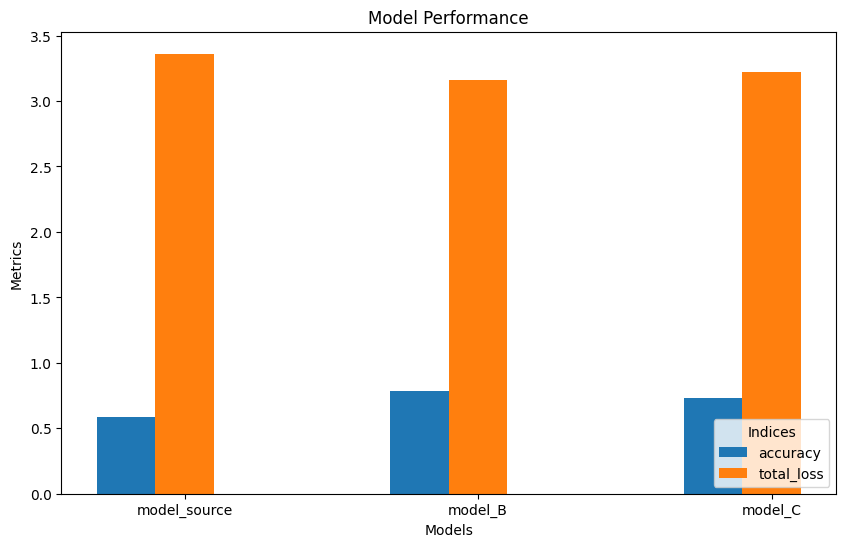

In [ ]:
%matplotlib inline


plt.figure(figsize=(10, 6))



bar_width = 0.2
bar_positions = np.arange(len(results_df.columns))


for i, index in enumerate(results_df.index):
    plt.bar(
        bar_positions + i * bar_width,
        results_df.loc[index],
        width=bar_width,
        label=index
    )

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Performance')
plt.xticks(bar_positions + bar_width, results_df.columns)
plt.legend(title='Indices', loc='lower right')

plt.show()
